In [2]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [3]:
#encoding. word encodig
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re

In [4]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt 
#http://www.nltk.org/
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gutda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gutda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("data/*.txt"))

In [8]:
#print books
print("Found books:")
book_filenames

Found books:


['data\\got1.txt',
 'data\\got2.txt',
 'data\\got3.txt',
 'data\\got4.txt',
 'data\\got5.txt']

In [9]:
#step 1 process data

#initialize rawunicode , we'll add all text to this one bigass file in memory
corpus_raw = u""
#for each book, read it, open it un utf 8 format, 
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1770659 characters long

Reading 'data\got2.txt'...
Corpus is now 4071041 characters long

Reading 'data\got3.txt'...
Corpus is now 6391405 characters long

Reading 'data\got4.txt'...
Corpus is now 8107945 characters long

Reading 'data\got5.txt'...
Corpus is now 9719485 characters long



In [10]:
#tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)
print(raw_sentences[0])

This edition contains the complete text of the original hardcover edition.


In [12]:
#convert into list of words
#remove unecessary characters, split into words, no hyhens and shit
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
# split each sentence: split it in words
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
#print an example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [15]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


In [16]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more trainig them, but more generalized
num_features = 200

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


In [24]:
#train model on sentneces
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=100)

(140443171, 181810300)

In [25]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [23]:
#load model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [24]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
#put it all into a giant matrix
all_word_vectors_matrix = thrones2vec.wv.syn0

c:\users\gutda\.virtualenvs\hslu_kbdss-master-sy3c7w-b\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [26]:
#train
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [30]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [31]:
points.head(10)

,word,x,y
0,This,-27.301893,-48.302395
1,edition,30.224291,45.017311
2,the,-46.797592,-38.811211
3,complete,11.771937,53.551327
4,of,-44.884907,-30.644213
5,original,18.286863,-50.244331
6,hardcover,7.616927,-46.173454
7,ONE,18.205601,9.540329
8,A,-45.688869,-36.987408
9,OF,0.591021,2.847754


In [32]:
#plot
sns.set_context("poster")

<AxesSubplot:xlabel='x', ylabel='y'>

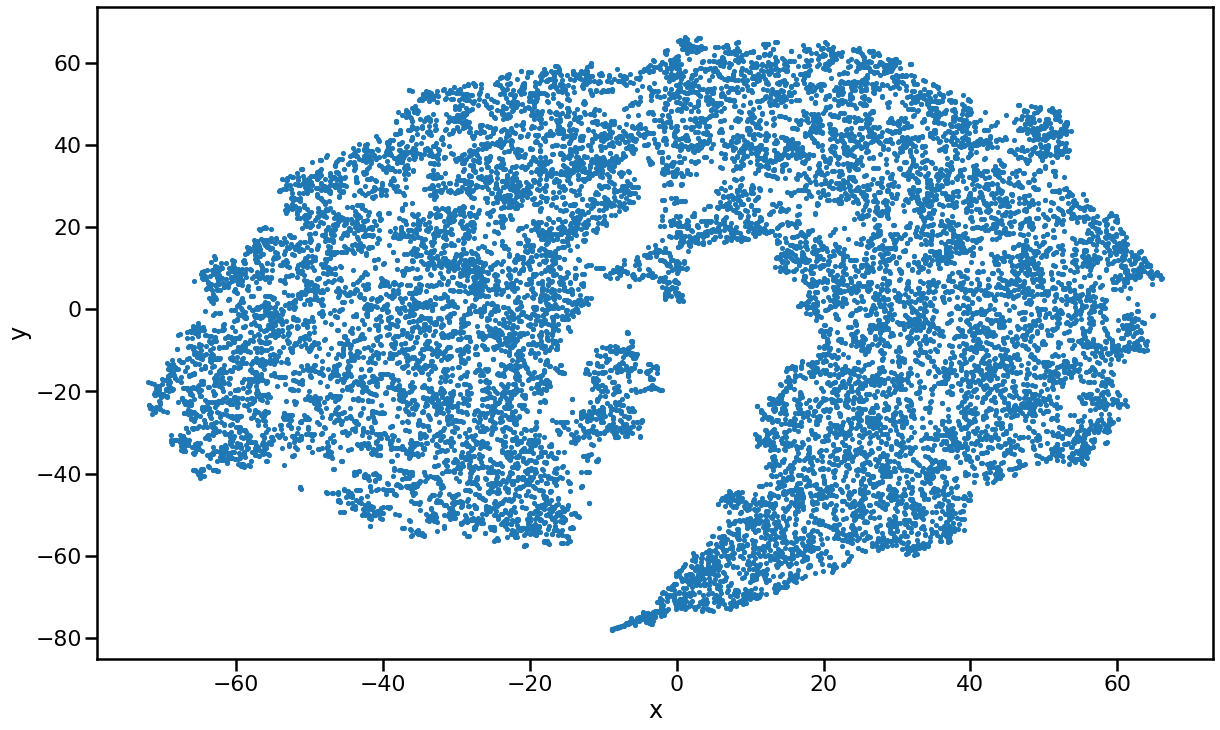

In [33]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [34]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

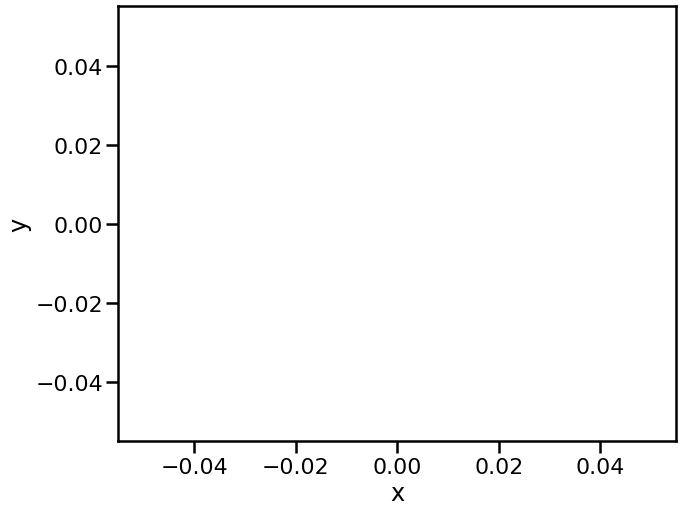

In [35]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

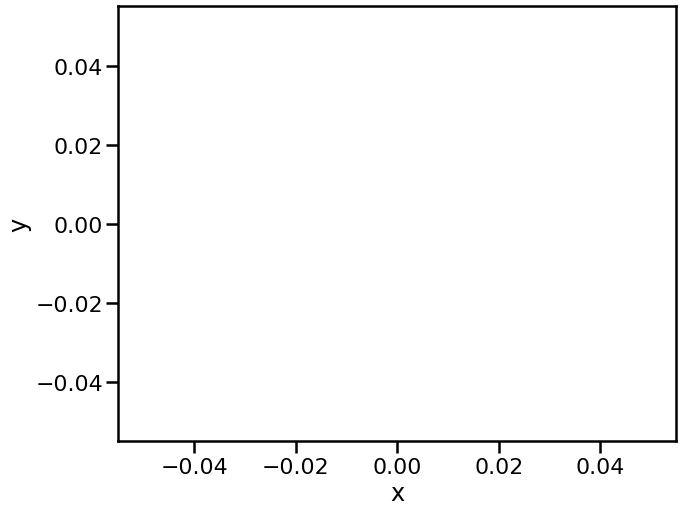

In [36]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

In [37]:
thrones2vec.most_similar("Stark")

c:\users\gutda\.virtualenvs\hslu_kbdss-master-sy3c7w-b\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Eddard', 0.9586166143417358),
 ('Lannister', 0.9584421515464783),
 ('Arryn', 0.9483989477157593),
 ('Greyjoy', 0.9475982785224915),
 ('Tully', 0.9388763904571533),
 ('Prince', 0.9370943307876587),
 ('Baratheon', 0.9365517497062683),
 ('Tyrell', 0.9338110685348511),
 ('murdered', 0.9327489137649536),
 ('Rhaegar', 0.928057074546814)]

In [38]:
thrones2vec.most_similar("Aerys")

c:\users\gutda\.virtualenvs\hslu_kbdss-master-sy3c7w-b\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Renly', 0.9795435667037964),
 ('Targaryen', 0.9776596426963806),
 ('Robert', 0.9757128357887268),
 ('Joffrey', 0.9745234251022339),
 ('Aegon', 0.9722726345062256),
 ('Greyjoy', 0.9719573259353638),
 ('Tommen', 0.9705213904380798),
 ('Hoster', 0.9693929553031921),
 ('Young', 0.9685542583465576),
 ('Edmure', 0.9667637348175049)]

In [39]:
thrones2vec.most_similar("direwolf")

c:\users\gutda\.virtualenvs\hslu_kbdss-master-sy3c7w-b\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('body', 0.9629878401756287),
 ('cell', 0.9606178402900696),
 ('raven', 0.9603822231292725),
 ('stump', 0.960354208946228),
 ('giant', 0.9568725824356079),
 ('corpse', 0.9568216800689697),
 ('seated', 0.9566185474395752),
 ('godswood', 0.9558926224708557),
 ('sitting', 0.9546233415603638),
 ('silent', 0.9546122550964355)]

In [40]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [41]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as squire is related to Riverrun
Jaime is related to sword, as Davos is related to wine
Arya is related to Nymeria, as answer is related to dragons


c:\users\gutda\.virtualenvs\hslu_kbdss-master-sy3c7w-b\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'answer'

In [1]:
field = [[0, 1, 1, 1, 0, 0],
         [0, 0, 1, 1, 0, 1],
         [0, 0, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [0, 1, 1, 0, 0, 1],
         [0, 1, 1, 0, 0, 0]]

In [6]:
def FloodFill(x, y, old_color, new_color):
    if field[x][y] == old_color:
        print(f"visited cell at {x}, {y}")
        field[x][y] == new_color
        FloodFill(x, y-1, old_color, new_color)
        FloodFill(x-1, y, old_color, new_color)
        FloodFill(x, y+1, old_color, new_color)
        FloodFill(x+1, y, old_color, new_color)

In [11]:
FloodFill(3, 2, 1, 2)

visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell 

visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell 

visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell at 3, 0
visited cell at 3, 2
visited cell at 3, 1
visited cell 

RecursionError: maximum recursion depth exceeded while calling a Python object

In [10]:
print(field[3][0])

1


In [ ]:
Farbe ändern
Rauf
Links
Runter
Rechts